# 1.Project Overview

* __Objective__ : Track price changes in maggie 12-pack over time
* __Why__ : To detect inflation trend
* __Data sources__ : Wayback machine - previous html pages of amazon listing
* __Tools__ : BeautifulSoup,Sqlite,numpy,pandas,matplotlib,seaborn

__Business question__ : Did nestle increase maggie price faster than food inflation ?

In [1]:
import os
import time
import re
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import sqlite3
from tqdm import tqdm

In [101]:
# wayback cdx config
url='http://web.archive.org/cdx/search/cdx'
user_agent='Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/142.0.0.0 Safari/537.36'
headers={'User_Agent':user_agent}
target='www.amazon.in/dp/B07B4KQRZG*'
params={'url':target,
        'output':'json',
        'filter':'statuscode:200',
        'fl':'original,timestamp',
        'collapse':'timestamp:6'}


# file paths
maggie_scraped_df_path=os.path.join('data','processed','maggie_scraped_df.csv')
maggie_raw_data_path=os.path.join('data','raw','maggie_raw_data.txt')
general_cpi_path=os.path.join('data','raw','General_Index_Sep20-To-Oct25.csv')
food_cpi_path=os.path.join('data','raw','Food_Price_Index_Sep20-To-Oct25 .csv')

os.makedirs(os.path.dirname(maggie_scraped_df_path),exist_ok=True)
os.makedirs(os.path.dirname(maggie_raw_data_path),exist_ok=True)

# to prevent ipban in wayback machine 
timeout=10
sleep_time=np.random.randint(1,5,1)[0]

# database name & schema
db_name='inflation.db'
product_data=[('Maggi 2-Minute Noodles Masala (Pack of 12)','INR')]
db_schema={ 'products': '''product_id integer primary key autoincrement, 
                           product_name text unique, 
                           base_currency text''',
            'price_history':'''record_id integer primary key autoincrement,
                               product_id integer,
                               record_date text,
                               price real,
                               weight_grams real,
                               foreign key(product_id) references products(product_id),
                               unique(product_id,record_date)''',
            'economic_indicators':'''record_date text primary key,
                                     general_cpi real,
                                     food_cpi real'''}

# 2.Url Collection Summary

* covers data from __2020__ to __2023__
* __total Unique entries__ : 373
* used statuscode: 200 and collapse so only get valid pages and no dublicates

In [102]:
def get_response(method,url,headers=None,params=None):
    """ Excutes https request with randomized delays and error handlings
    Args:
        method(str):'GET' or 'POST'
        url(str):the target url
        headers(dict,optional):browser to avoid bot detection
        params(dict,optional):url parameters
        
    Returns:
        requests.Response object if success either return None"""

    # prevents from hitting ratelimit or ipban
    time.sleep(sleep_time)
    response=None
    try :
      response=requests.request(method='GET',url=url,headers=headers,params=params,timeout=timeout)
    
    except requests.exceptions.HTTPError as errh:
        print(f'HTTP Error for {url} : {errh}')
    except requests.exceptions.ConnectionError as errc:
        print(f'Connection Error for {url}: {errc}')
    except requests.exceptions.Timeout as errt:
        print(f'Timeout Error for {url}: {errt}')
    except requests.exceptions.RequestException as err:
        print(f'Something Else for {url}: {err}')
    return response

In [103]:
# to prevent everytime asking for the data from wayback machine

if os.path.exists(maggie_raw_data_path):
    
    with open(maggie_raw_data_path) as f:
        maggie_raw_data=json.load(f)
        
    print(f'maggie_raw_data loaded succefully type is :{type(maggie_raw_data)} and length is : {len(maggie_raw_data)}')

else :
    print(f'file not exists at {maggie_raw_data_path} fetching data from wayback machine')
    
    response=get_response(method='GET',url=url,headers=headers,params=params)
    if response is not None and response.status_code==200:
        maggie_raw_data=response.json()
        print(f'maggie_raw_data fetched succefully type is :{type(maggie_raw_data)} and length is : {len(maggie_raw_data)}')

        # to load the data latter 
        with open(maggie_raw_data_path,'w+') as f:
            json.dump(maggie_raw_data,f)
        print(f'file saved at {maggie_raw_data_path}')
    else:
        print('failed to retrieve data')

maggie_raw_data loaded succefully type is :<class 'list'> and length is : 848


In [104]:
def df_cleaner(df,column_name='record_date'):
    """ Convert record_date column to datatype datetime, sortvalues based on date and reset index
    Args : 
        df(dataframe) : dataframe object
        column_name(str) : column you want to convert to datetime object
    return 
        df(clean version of given dataframe): """
    
    df[column_name]=df[column_name].astype('datetime64[ns]')
    df=df.sort_values(by=column_name)
    df=df.reset_index(drop=True)
    return df

In [105]:
maggie_raw_df=pd.DataFrame(maggie_raw_data[1:],columns=maggie_raw_data[0])

maggie_raw_df['record_date']=maggie_raw_df['timestamp'].astype('datetime64[ns]').apply(lambda x:x.date())

maggie_raw_df.drop_duplicates(subset=['record_date'],inplace=True)
df_cleaner(maggie_raw_df)

# this urls allows us to scrape data
maggie_raw_df['webpages']='https://web.archive.org/web/'+maggie_raw_df['timestamp']+'/'+maggie_raw_df['original']
maggie_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, 0 to 846
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   original     373 non-null    object        
 1   timestamp    373 non-null    object        
 2   record_date  373 non-null    datetime64[ns]
 3   webpages     373 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 14.6+ KB


# 3.Data Collection Summary

* Used __beautifulSoup__ to extract title and price from urls
* Using __regular expression__ extract weight and no of packs from title
* __total non-null entries__ : 169

In [106]:
def create_soup(html_content):
    """create a beautiful soup object use for scarping"""
    soup=BeautifulSoup(html_content,'html.parser')
    return soup
    
def extraction(soup):
    """Find title and price from html content.Amazon frequently change their price class
    So it handle it with cases
    
    Args : 
        beautiful soup object
        
    Return : 
        result dict contains title and price if not find infomation returns None"""
    
    result={'title':None,'price':None}

    if soup.find(id='productTitle') is None:
      return None
    else:
      webpage_title=soup.find(id='productTitle').get_text().strip()
      result['title']=webpage_title

    # amazon change classes frequent so need to check cases
    if soup.find('span',{'class':"a-price-whole"}) is not None:
      webpage_price=soup.find('span',{'class':"a-price-whole"}).get_text().strip()

    elif soup.find(id='priceblock_dealprice') is not None:
      webpage_price=soup.find(id='priceblock_dealprice').get_text().strip()

    elif soup.find(id='priceblock_ourprice') is not None:
      webpage_price=soup.find(id='priceblock_ourprice').get_text().strip()

    else:
      webpage_price=None

    if webpage_price is not None:
      webpage_final_price=re.sub(r'[^\d.]','',webpage_price)
      result['price']=float(webpage_final_price)

    else:
      result['price']=webpage_price

    return result

In [107]:
if os.path.exists(maggie_scraped_df_path) :
    print('Found maggie_scraped_df loaded')
    maggie_scraped_df=pd.read_csv(maggie_scraped_df_path)
    print(maggie_scraped_df.head())
else :
    print(f'File not exists at /{path}, confirm file location or start scraping data using the script below')

Found maggie_scraped_df loaded
                                             title  price
0  Maggi 2-Minute Noodles Masala, 70g (Pack of 12)  144.0
1  Maggi 2-Minute Noodles Masala, 70g (Pack of 12)  129.6
2  Maggi 2-Minute Noodles Masala, 70g (Pack of 12)  129.6
3  Maggi 2-Minute Noodles Masala, 70g (Pack of 12)  129.6
4  Maggi 2-Minute Noodles Masala, 70g (Pack of 12)  129.6


In [108]:
## !! WARNING:scraping more than 373 urls takes time, so you can direct use the maggie_scraped_df from data/processed/maggie_scraped_df.csv
## If you have enough time to spend give it a shot. 

# all_data=[]
# for webpage in tqdm(maggie_raw_df['webpages']):
#     response=get_response(method='GET',url=webpage,headers=headers)
#     if response is None:
#         print(f'failed to fetch : {webpage}')
#         continue
#     html_content=response.text
#     soup=create_soup(html_content)
#     clean_data=extraction(soup)
#     if clean_data is None:
#         continue
#     all_data.append(clean_data)

# print(f'extrection complete. valid recors are {len(all_data)}')

In [109]:
# maggie_scraped_df=pd.DataFrame(all_data)
# maggie_scraped_df.to_csv(path,index=False)

In [110]:
maggie_concat_df=pd.concat([maggie_raw_df,maggie_scraped_df],axis=1)
maggie_concat_df=maggie_concat_df.dropna()
maggie_concat_df=df_cleaner(maggie_concat_df)
maggie_concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   original     96 non-null     object        
 1   timestamp    96 non-null     object        
 2   record_date  96 non-null     datetime64[ns]
 3   webpages     96 non-null     object        
 4   title        96 non-null     object        
 5   price        96 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 4.6+ KB


In [111]:
def extract_product_details(title_text):
  """Use regex expressions to find no of packs , weight and unit of weight from the title
    Args : 
        title_text(srt)
    Returns:
        dict containing information releted to the product"""
  result={}
  if title_text is not None:

    no_of_packs=1
    grps=re.search(r'Pack of\s+(\d+)',title_text,flags=re.IGNORECASE)
    if grps:
      no_of_packs=int(grps.group(1))
      result['no_of_packs']=no_of_packs

    grps2=re.search(r'(\d*\.?\d+)\s*(g|kg|gm|gram|ml|l)',title_text,flags=re.IGNORECASE)
    if grps2:
      weight_per_pack=float(grps2.group(1))
      unit=grps2.group(2)
      result['weight_per_pack']=weight_per_pack
      result['unit']=unit
        # the weight contains only two values 70 or 840 so if the weight is already 840 no need to multiply it by the no of packs
      if weight_per_pack==840 :
        total_weight=weight_per_pack
      else:
        total_weight=weight_per_pack*no_of_packs

      result['total_weight']=total_weight

    return result
  else :
    print(f"Warning: Could not extract weight from title: {title_text}")
    result={'weight_per_pack':None,'unit':None,'no_of_packs':None,'total_weight':None}
    return result

In [112]:
maggie_information_df=maggie_concat_df['title'].apply(extract_product_details).apply(pd.Series)
# to check if there is any other unit then gram
print(maggie_information_df['unit'].unique())

['g' 'G']


In [113]:
maggie_all_df=pd.concat([maggie_concat_df,maggie_information_df],axis=1)

# it's a standard way to compair product prices
maggie_all_df['price_per_100g']=(maggie_all_df['price']/maggie_all_df['total_weight'])*100
maggie_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   original         96 non-null     object        
 1   timestamp        96 non-null     object        
 2   record_date      96 non-null     datetime64[ns]
 3   webpages         96 non-null     object        
 4   title            96 non-null     object        
 5   price            96 non-null     float64       
 6   no_of_packs      91 non-null     float64       
 7   weight_per_pack  96 non-null     float64       
 8   unit             96 non-null     object        
 9   total_weight     96 non-null     float64       
 10  price_per_100g   96 non-null     float64       
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 8.4+ KB


# 4.Database summary 

* __tables__ : products , price_history , economic indicators
* __Handling__ : use insert or ignore / try expect to prevent dublicate entries

In [114]:
# using with to prevent lock in database
with sqlite3.connect(db_name) as con:
    cur=con.cursor()
    # sqlite3 doesn't on foreign key automatic...
    cur.execute('PRAGMA foreign_keys=ON;')
    
    # define schema in start for code accecibility
    for table_name,columns in db_schema.items():
        cur.execute(f'create table if not exists {table_name} ({columns})')
    # confirmation...
    res=cur.execute('select name from sqlite_master where type="table"')
    print(res.fetchall())

    cur.executemany("""insert or ignore into products (product_name,base_currency) values
                (?,?)""",product_data)

    con.commit()    
    # confirming
    res=cur.execute('select * from products')
    print('products :',res.fetchall())

[('products',), ('sqlite_sequence',), ('price_history',), ('economic_indicators',)]
products : [(1, 'Maggi 2-Minute Noodles Masala (Pack of 12)', 'INR')]


In [115]:

# to prevent error while adding the data from the df
maggie_sql_df=maggie_all_df.rename(columns={'total_weight':'weight_grams'})
maggie_sql_df['product_id']=1

# database doesn't recognize datetime format so it will save the date in long string.
maggie_sql_df['record_date']=maggie_sql_df['record_date'].astype('str')

maggie_sql_df=maggie_sql_df.drop(['original','timestamp','webpages','title','no_of_packs','weight_per_pack','unit','price_per_100g'],axis=1)
maggie_sql_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   record_date   96 non-null     object 
 1   price         96 non-null     float64
 2   weight_grams  96 non-null     float64
 3   product_id    96 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 3.1+ KB


In [116]:
# General index & Consumer food price index downloaded from https://cpi.mospi.gov.in


if os.path.exists(general_cpi_path):
    print(f'{general_cpi_path} found file loaded')
    general_index_df=pd.read_csv(general_cpi_path,header=1)
else :
    print(f'{general_cpi_path} not found')

if os.path.exists(food_cpi_path):
    print(f'{food_cpi_path} found file loaded')
    food_price_index_df=pd.read_csv(food_cpi_path,header=1)
else :
    print(f'{general_cpi_path} not found')


general_index_df['Year']=general_index_df['Year'].astype('str')
general_index_df['Date']=general_index_df['Month']+'-'+general_index_df['Year']
# to match the dates with maggie_sql_df
general_index_df['Date']=general_index_df['Date'].astype('datetime64[ns]').astype('str')
general_index_df=general_index_df.drop(columns=['State','Group','Sub Group','Description','Rural','Urban','Status','Month','Year','Unnamed: 10'])

food_price_index_df['Year']=food_price_index_df['Year'].astype('str')
food_price_index_df['Date']=food_price_index_df['Month']+'-'+food_price_index_df['Year']
# to match dates with maggie_sql_df
food_price_index_df['Date']=food_price_index_df['Date'].astype('datetime64[ns]').astype('str')
food_price_index_df=food_price_index_df.drop(columns=['State','Group','Sub Group','Description','Rural','Urban','Status','Month','Year','Unnamed: 10'])

general_index_df.rename(columns={'Combined':'general_cpi','Date':'record_date'},inplace=True)
food_price_index_df.rename(columns={'Combined':'food_cpi','Date':'record_date'},inplace=True)

# concating
cpi_df=pd.merge(general_index_df,food_price_index_df,on='record_date')
cpi_df.info()

data/raw/General_Index_Sep20-To-Oct25.csv found file loaded
data/raw/Food_Price_Index_Sep20-To-Oct25 .csv found file loaded
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   general_cpi  62 non-null     float64
 1   record_date  62 non-null     object 
 2   food_cpi     62 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.6+ KB


In [117]:
with sqlite3.connect(db_name) as con:
    cur=con.cursor()

    try:
        maggie_sql_df.to_sql('price_history', con=con, if_exists='append', index=False)
    except sqlite3.IntegrityError:
        print("Some data already exists in price_history. Ignoring duplicates.")
    # confirming..
    res=cur.execute('select count(*) from price_history' )
    print('price_history :',res.fetchone())
    
    try:
        cpi_df.to_sql('economic_indicators',con=con,if_exists='append',index=False,method='multi')
    except sqlite3.IntegrityError:
        print("Some data already exists in economic_indicators. Ignoring duplicates.")
    # confirming..
    res=cur.execute('select count(*) from economic_indicators')
    print('economic_indicators :',res.fetchone())

Some data already exists in price_history. Ignoring duplicates.
price_history : (169,)
Some data already exists in economic_indicators. Ignoring duplicates.
economic_indicators : (62,)


# 5.Sql operations

__5.1 What are the dates where maggie has highest and lowest prices__

In [118]:
with sqlite3.connect(db_name) as con:
    cur=con.cursor()

    res=cur.execute( 'select price from price_history  order by price desc limit 1 ')
    print(res.fetchall())

[(183.0,)]


In [119]:
with sqlite3.connect(db_name) as con:
    cur=con.cursor()

    res=cur.execute( 'select price from price_history order by price limit 1')
    print(res.fetchall())

[(129.0,)]


__5.2 How many records do we have per Year?__

In [120]:
with sqlite3.connect(db_name) as con:
    cur=con.cursor()

    res=cur.execute( ''' with year_table as (select strftime('%Y',record_date) as yr from price_history)
                                select yr,count(*) from year_table group by yr''')
    print(res.fetchall())

[('2020', 15), ('2021', 29), ('2022', 81), ('2023', 44)]


__5.3__

__5.4__

# 6. Exploratory Data Analysis(EDA)

* __6.1 loading data from the database and resapmle maggie data on months for better compartion with Influation Index__

In [121]:
with sqlite3.connect(db_name) as con:
    cur=con.cursor()

    maggie_df=pd.read_sql('select record_date,price,weight_grams from price_history',con=con)
    cpi_df=pd.read_sql('select * from economic_indicators',con=con)

maggie_df=df_cleaner(maggie_df)
# to prevent noise in the price from amazon
maggie_df['price_per_100g']=(maggie_df['price']/maggie_df['weight_grams'])*100
maggie_df = maggie_df.resample('MS', on='record_date').mean().ffill().reset_index()
maggie_df=maggie_df.drop([4,31,32]).reset_index(drop=True)

maggie_bi_df=maggie_df.drop('price_per_100g',axis=1)
maggie_bi_df['record_date']=maggie_bi_df['record_date'].astype('str')

maggie_merge_bi_df=pd.merge(maggie_bi_df,cpi_df)
maggie_merge_bi_df.to_csv('maggie_inflation_analysis.csv',index=False)

In [122]:
maggie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   record_date     31 non-null     datetime64[ns]
 1   price           31 non-null     float64       
 2   weight_grams    31 non-null     float64       
 3   price_per_100g  31 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.1 KB


* __6.2 Descriptive Stat for price_per_100g column__
    * min price = 15.42
    * max price = 19.28
    * mean = 17.84
    * median = 18.715
    * std = 1.343

In [123]:
print(maggie_df['price_per_100g'].median())
maggie_df.describe()

18.622448979591837


,record_date,price,weight_grams,price_per_100g
count,31,31.000000,31.0,31.000000
mean,2021-12-29 06:58:03.870967808,149.052161,840.0,17.744305
min,2020-09-01 00:00:00,129.600000,840.0,15.428571
25%,2021-05-16 12:00:00,140.000000,840.0,16.666667
50%,2022-01-01 00:00:00,156.428571,840.0,18.622449
75%,2022-08-16 12:00:00,159.291667,840.0,18.963294
max,2023-06-01 00:00:00,160.000000,840.0,19.047619
std,NaN,11.406820,0.0,1.357955


__6.3 Visualization : Price Over Time__

Text(0.5, 1.0, 'Price Over Time Line chart')

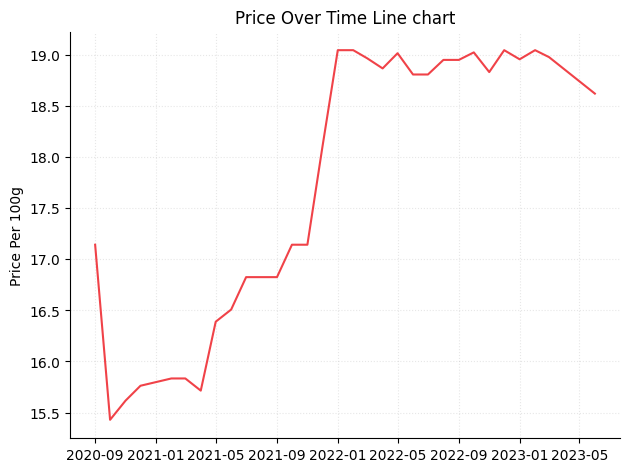

In [124]:
sns.lineplot(maggie_df,x='record_date',y='price_per_100g',lw=1.5 , color='#f04248')

sns.despine()

plt.grid(alpha=0.3,ls='dotted')
plt.tight_layout()

plt.ylabel('Price Per 100g')
plt.xlabel('')
plt.title('Price Over Time Line chart')

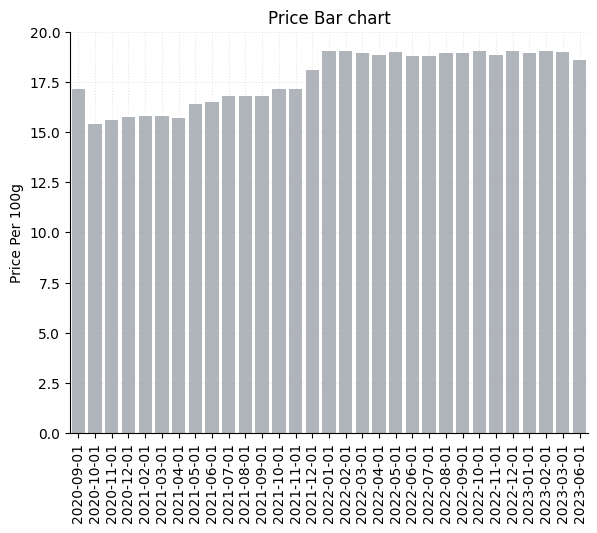

In [125]:
sns.barplot(data=maggie_df,y='price_per_100g',x='record_date',color='#adb5bd')
sns.despine()

plt.grid(alpha=0.3,ls='dotted')
plt.tight_layout()

plt.xticks(rotation=90)
plt.ylabel('Price Per 100g')
plt.xlabel('')
plt.title('Price Bar chart')

plt.show()

__6.4 Monthly Price Change__

In [126]:
maggie_df=maggie_df.set_index('record_date')
maggie_df['mom%']=(maggie_df.pct_change()['price_per_100g'])*100
maggie_df.reset_index(inplace=True)
maggie_df.head()

,record_date,price,weight_grams,price_per_100g,mom%
0,2020-09-01,144.000,840.0,17.142857,NaN
1,2020-10-01,129.600,840.0,15.428571,-10.000000
2,2020-11-01,131.175,840.0,15.616071,1.215278
3,2020-12-01,132.400,840.0,15.761905,0.933867
4,2021-02-01,133.000,840.0,15.833333,0.453172


Text(0.5, 1.0, 'Price % change over months')

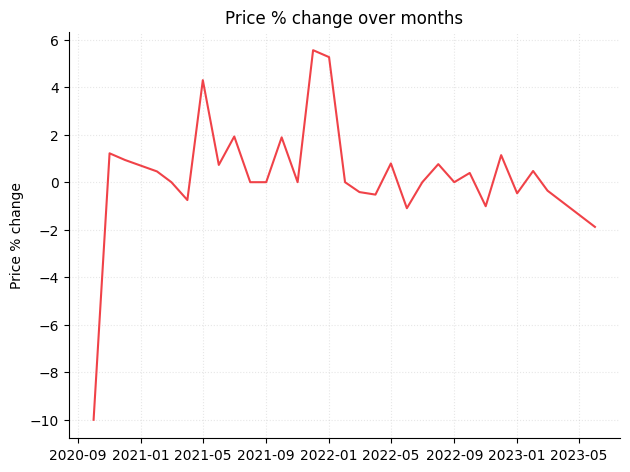

In [127]:
sns.lineplot(data=maggie_df,x='record_date',y='mom%',color='#f04248')

sns.despine()

plt.grid(alpha=0.3,ls='dotted')
plt.tight_layout()

plt.ylabel('Price % change')
plt.xlabel('')
plt.title('Price % change over months')

In [128]:
maggie_df.describe()['mom%']

count    30.000000
mean      0.309609
min     -10.000000
25%      -0.401786
50%       0.000000
75%       0.897561
max       5.555556
std       2.589439
Name: mom%, dtype: float64

# 7.Price Distribution 
* __1.box plot__ - shows outliers
* __2.histogram__ - shows distribution 

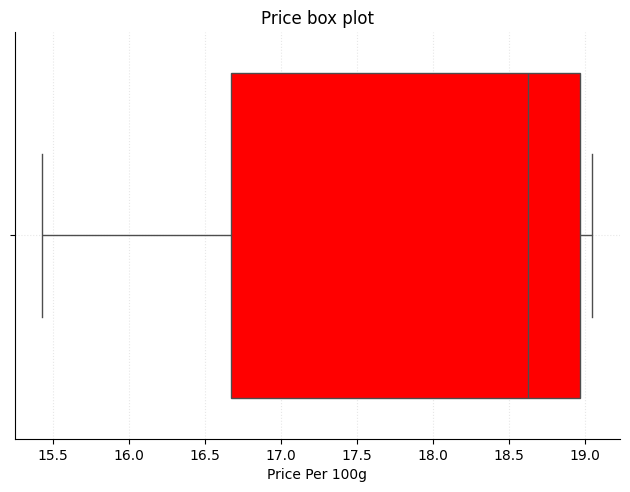

In [129]:
sns.boxplot(data=maggie_df,x='price_per_100g',color='red',saturation=1.5)

sns.despine()

plt.grid(alpha=0.3,ls='dotted')
plt.tight_layout()

plt.ylabel('')
plt.xlabel('Price Per 100g')
plt.title('Price box plot')
plt.show()

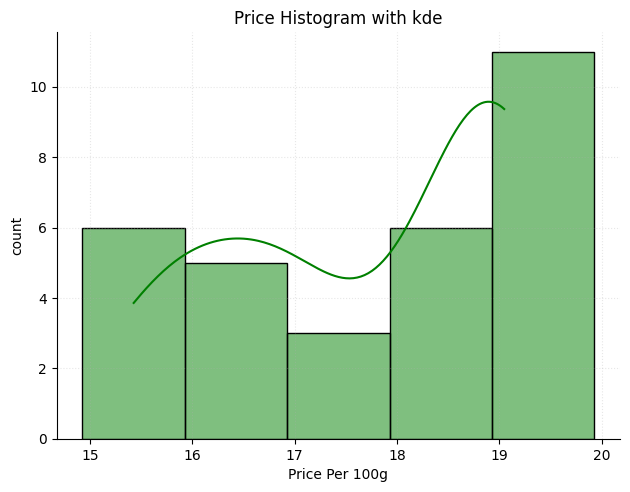

In [130]:
sns.histplot(data=maggie_df,x='price_per_100g',kde=True,color='green',discrete=True)

sns.despine()

plt.grid(alpha=0.3,ls='dotted')
plt.tight_layout()

plt.ylabel('count')
plt.xlabel('Price Per 100g')
plt.title('Price Histogram with kde')
plt.show()

# 8.Business Insights

* __Merge both dataframe based on record_date__
* __Corrlation (price_per_100g with food_cpi)__ : 0.69
* __Normalize value based on first value__
* Plot __maggie_price__ and __food_inflation__
* Plot __ratio__

In [131]:
cpi_df=df_cleaner(cpi_df)

In [132]:
merge_df=pd.merge(maggie_df,cpi_df,on='record_date')
merge_df=df_cleaner(df=merge_df)
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   record_date     31 non-null     datetime64[ns]
 1   price           31 non-null     float64       
 2   weight_grams    31 non-null     float64       
 3   price_per_100g  31 non-null     float64       
 4   mom%            30 non-null     float64       
 5   general_cpi     31 non-null     float64       
 6   food_cpi        31 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.8 KB


In [133]:
merge_df.corr(numeric_only=True)['price_per_100g']

price             1.000000
weight_grams           NaN
price_per_100g    1.000000
mom%              0.163207
general_cpi       0.873524
food_cpi          0.789712
Name: price_per_100g, dtype: float64

In [138]:
# In first entry there is very high value of price due to amazon price flcuation so i have to use 4 days average. for better results 
base_price=merge_df['price_per_100g'][:4].mean()
base_food_cpi=merge_df['food_cpi'][:4].mean()

merge_df['maggie_index']=(merge_df['price_per_100g']/base_price)*100
merge_df['food_inflation']=(merge_df['food_cpi']/base_food_cpi)*100

merge_df

,record_date,price,weight_grams,price_per_100g,mom%,general_cpi,food_cpi,maggie_index,food_inflation,ratio
0,2020-09-01,144.000000,840.0,17.142857,NaN,156.4,161.6,107.227626,98.883280,1.084386
1,2020-10-01,129.600000,840.0,15.428571,-1.000000e+01,158.4,165.5,96.504863,101.269696,0.952949
2,2020-11-01,131.175000,840.0,15.616071,1.215278e+00,158.9,166.0,97.677666,101.575646,0.961625
3,2020-12-01,132.400000,840.0,15.761905,9.338670e-01,157.3,160.6,98.589845,98.271378,1.003241
4,2021-02-01,133.000000,840.0,15.833333,4.531722e-01,156.6,155.5,99.036627,95.150681,1.040840
5,2021-03-01,133.000000,840.0,15.833333,0.000000e+00,156.8,155.0,99.036627,94.844730,1.044197
6,2021-04-01,132.000000,840.0,15.714286,-7.518797e-01,157.8,156.4,98.291991,95.701392,1.027070
7,2021-05-01,137.666667,840.0,16.388889,4.292929e+00,160.4,159.4,102.511596,97.537097,1.051001
8,2021-06-01,138.666667,840.0,16.507937,7.263923e-01,161.3,161.3,103.256232,98.699709,1.046166
9,2021-07-01,141.333333,840.0,16.825397,1.923077e+00,162.5,162.9,105.241929,99.678752,1.055811


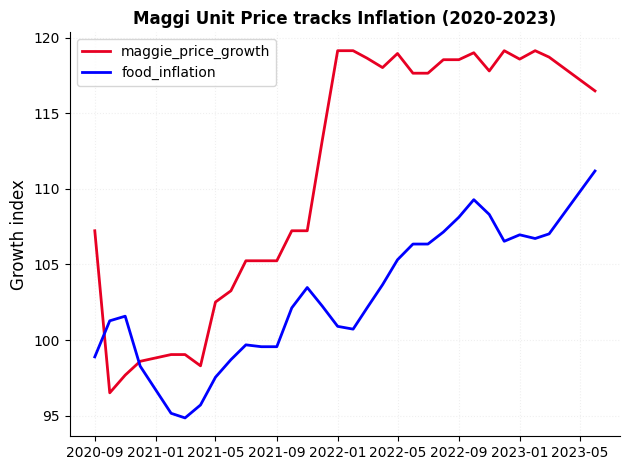

In [135]:
# ploting the maggie price vs date graph

# line maggie index
sns.lineplot(merge_df,
             x='record_date',
             y='maggie_index',
             color='#E70023',
             lw=2,
             label='maggie_price_growth'
             )

# line food inflation 
sns.lineplot(merge_df,
             x='record_date',
             y='food_inflation',
             color='blue',
             lw=2,
             label='food_inflation'
             )

sns.despine()


plt.xlabel('')
plt.ylabel('Growth index',fontsize=12)
plt.grid(True,alpha=0.5,color='#e0e0e0',ls='dotted')
plt.title('Maggi Unit Price tracks Inflation (2020-2023)',fontweight='bold')

plt.tight_layout()

In [136]:
merge_df['ratio']=merge_df['maggie_index']/merge_df['food_inflation']

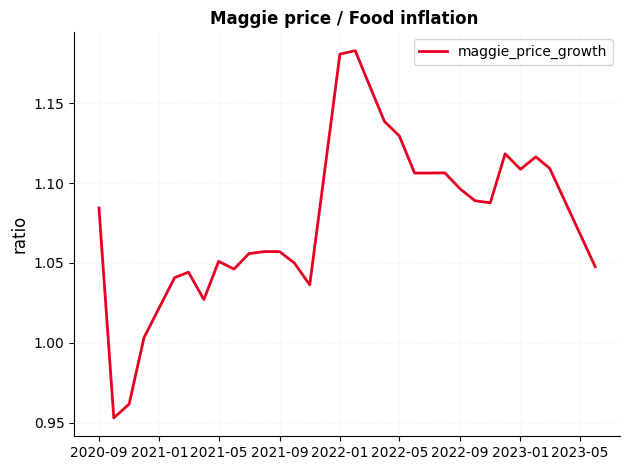

In [137]:
# ploting the maggie price vs date graph

# line maggie index
sns.lineplot(merge_df,
             x='record_date',
             y='ratio',
             color='#E70023',
             lw=2,
             label='maggie_price_growth'
             )

sns.despine()

plt.xlabel('')
plt.ylabel('ratio',fontsize=12)
plt.grid(True,alpha=0.5,color='#e0e0e0',ls='dotted')
plt.title('Maggie price / Food inflation ',fontweight='bold')

plt.tight_layout()

# Conclusion

__Anticipatory Pricing (2021-2022)__: Maggi prices spiked before the general inflation peak. By Jan 2022, Maggi's price index (111.1) was significantly higher than the general Food Inflation index (102.0).

__Inflation Catch-Up (2022-2023)__: Post-2022, Maggi prices stabilized (flat line) while general inflation continued to rise (102 $\to$ 108). This suggests Nestle front-loaded their price hikes to secure margins early.

__No Shrinkflation__: Weight remained constant at 840g, confirming a pure price-strategy approach.